## Работа Закировой Марфы, Б06-906а

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

In [2]:
z           = 10
B           = 50
L           = 500
p0          = 1e7
p_inj       = 15 * 1e6
p_prod      = 5 * 1e6

k           = 1e-14
mu          = 1e-3
fi          = 0.2

rho0        = 1000
cf          = 1e-4 / 1e5
p_op         = 120 * 1e5

In [3]:
LN = 100
axes_x = np.linspace(0, 
                 L, 
                 LN)
h = np.diff(axes_x)[0]

TN = 100
num_days = 10
num_hours = 24

axes_t = np.linspace(0, 
                 num_days * num_hours * 60 * 60, 
                 TN+1)
tau = np.diff(axes_t)[0]

p = np.zeros([TN+1, 
              LN])
p[0, :] = p0

In [4]:
p[0][0] = p_inj
p[0][-1] = p_prod

In [5]:
rho = lambda p: rho0 * (1 + cf * (p - p_op))

def rho_next(n, i):
    if p[n][i] >= p[n][i+1]:
        return rho(p[n][i])
    else:
        return rho(p[n][i+1])

def rho_prev(n, i):
    if p[n][i-1] >= p[n][i]:
        return rho(p[n][i-1])
    else:
        return rho(p[n][i])

In [6]:
def triangle_slau(a, b, c, d):
    # прогонку сделала руками

    n = len(b)
    m = n - 1
    x, y, z = np.zeros(n), np.zeros(n), np.zeros(n)
    
    c = c + [0]
    x[0] = c[0] / b[0]
    y[0] = d[0] / b[0]

    for i in range(1, n):
        x[i] = c[i] / (b[i] - (a[i - 1] * x[i - 1]))
        y[i] = (d[i] - (a[i - 1] * y[i - 1])) / (b[i] - (a[i - 1]*x[i - 1]))

    z[m] = y[-1]
    
    for i in range(n - 2, -1, -1):
        z[i] = y[i] - (z[i + 1] * x[i])
    
    return z

In [7]:
for n in range(TN):
    c = [k * rho_prev(n, i) / (mu * h**2) 
         for i in range(1, LN - 1)] + [0]
    
    b = [0] + [k * rho_next(n, i) / (mu * h**2) 
         for i in range(1, LN - 1)]
    
    a = [1] + [-c[i-1] - b[i] - (fi * cf * rho0 / tau) 
         for i in range(1, LN-1)] + [1]
    
    d = [p_inj] + [-fi * cf * rho0 * p[n][i]/ tau 
         for i in range(1, LN-1)] + [p_prod]

    p[n+1, :] = triangle_slau(c, a, b, d) 

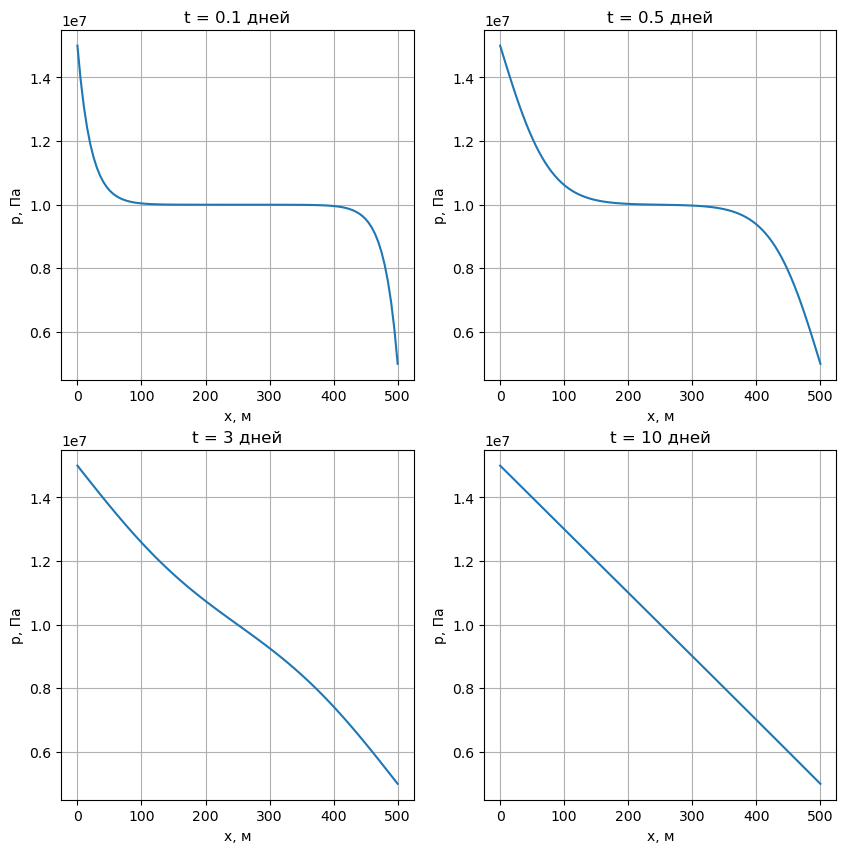

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))
days = [0.1, 0.5, 3, 10]
ax1.plot(axes_x, p[int(days[0] * 10)])
ax2.plot(axes_x, p[int(days[1] * 10)])
ax3.plot(axes_x, p[days[2] * 10])
ax4.plot(axes_x, p[days[3] * 10])

for i, ax in enumerate(fig.get_axes()):
    ax.set_title(f't = {days[i]} дней')
    ax.set(xlabel='x, м', ylabel='p, Па')
    ax.grid()

----



<h1><center>Полинейный метод Гаусса–Зейделя</center></h1>

![alt text](гаусс-зе.png "Title")



1. Используется сетка с распределенными узлами <br>
2. Шаблон на точках <br>
{$\varphi_{m\pm 1, k}^{n+1}, \varphi_{m,k}^{n+1}, \varphi_{m,k-1}^{n+1},\varphi_{m,k}^{n},$} <br>

In [38]:
lambd = 1e-4

fi_teor  = lambda t, x, y:  np.cos(np.pi * x) * np.sin(5 * np.pi  * y)  *  np.exp(-50 * (np.pi ** 2) * lambd * t)
# для граничных

fi_0yt  = lambda t, y:     np.sin(5 * np.pi * y) * np.exp(-50 * (np.pi  ** 2) * lambd * t)
fi_1yt  = lambda t, y:     -np.sin(5 * np.pi * y) * np.exp(-50 * (np.pi  ** 2) * lambd * t)

def solve(T, N_xy, return_h = False):
    ### генерируем сетки
    if T > 0 and N_xy>0:    
        axes_t = np.linspace(0, 1, T+1)
        axes_x = np.linspace(0, 1, N_xy+1)
        axes_y = np.linspace(0, 1, N_xy+1)

        tau = axes_t[1] - axes_t[0]
        h_xy = axes_x[1] - axes_x[0]
        delta = 0
        fi = np.zeros([T+1, N_xy+1, N_xy+1])

    ### ГУ
        fi[0, :, :]   = [[np.cos(np.pi * axes_x[i])  *  np.sin(5 * np.pi * axes_y[j]) for i in range(N_xy + 1)] for j in range(N_xy + 1)]
        fi[:, 0, :]   = [[fi_0yt(t, y) for y in axes_y] for t in axes_t]
        fi[:, N_xy, :] = [[fi_1yt(t, y) for y in axes_y] for t in axes_t]

        a = (-50 * lambd / (h_xy ** 2)) - (2 * lambd/(h_xy ** 2)) - (1/tau)
        b = lambd / (h_xy ** 2)
        c = 25 * lambd/(h_xy ** 2)

        c_array  = [0] 
        c_array += [c for m in range(1, N_xy)]
        
        b_array  = [0] 
        b_array += [b for m in range(1, N_xy)]

        a_array  = [1] 
        a_array += [a for l in range(1, N_xy)] 
        a_array += [1]

        a_x      = [b for m in range(1, N_xy)] 
        a_x     += [0]
        
        a_y = [c for m in range(1, N_xy)] 
        a_y += [0]

        for n in range(T):
            if n % 2 == 0:
                # по Оу

                for j in range(1, N_xy): 

                    d  = [fi_0yt(axes_t[n+1], axes_y[j])] 
                    d += [-(fi[n, i, j]/tau)-(b * fi[n+1, i, j-1])-(b * fi[n, i, j+1]) for i in range(1, N_xy)] 
                    d += [fi_1yt(axes_t[n+1], axes_y[j])]
                    
                    fi[n+1, :, j] = triangle_slau(a_y, a_array, c_array, d)
            else:
                # по Ох

                for i in range(1, N_xy):
                    d = [0]
                    d += [-(fi[n, i, j]/tau)-(c * fi[n+1, i-1, j])-(c * fi[n, i+1, j]) for j in range(1, N_xy)]
                    d += [0]
                    fi[n+1, i, :] = triangle_slau(a_x, a_array, b_array, d)


        for l in range(N_xy+1):
            for m in range(N_xy+1):
                delta = max(delta, np.abs(fi_teor(axes_t[-1], axes_x[l], axes_y[m]) - fi[-1, l, m]))
        if return_h:
            return delta, fi, h_xy
        else:
            return delta, fi
    
    else:
        return 0,0

In [32]:
d1, fi1 = solve(100, 100)
d1

1.3436096923435639

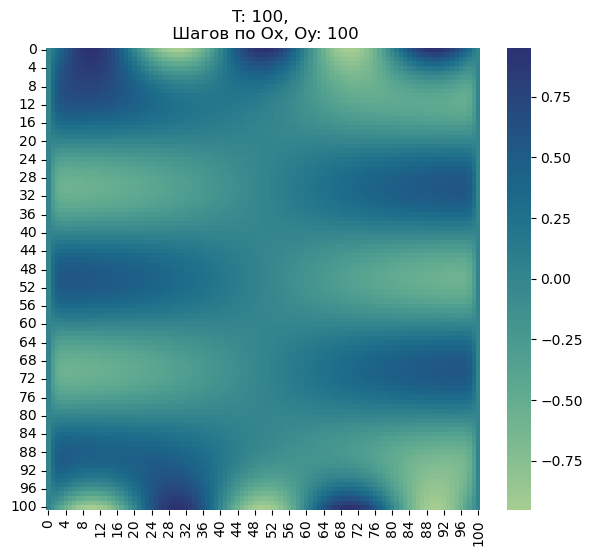

In [44]:
def plot_fi(T, N_xy, if_return_h = False):
    if if_return_h:
        delta, fi, h = solve(T, N_xy, return_h = if_return_h)
    else:
        h = 0
        delta, fi = solve(T, N_xy, return_h = if_return_h)

    plt.figure(figsize=(7,6))
    sns.heatmap(fi[-1, :, :], cmap="crest")
    plt.title(f'T: {T}, \n Шагов по Ox, Oy: {N_xy}')
    plt.show()
    return delta, fi, h

delta, fi, _ = plot_fi(100, 100)


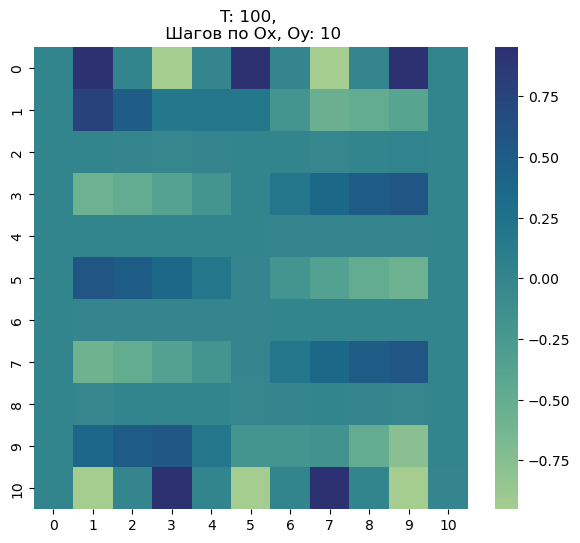

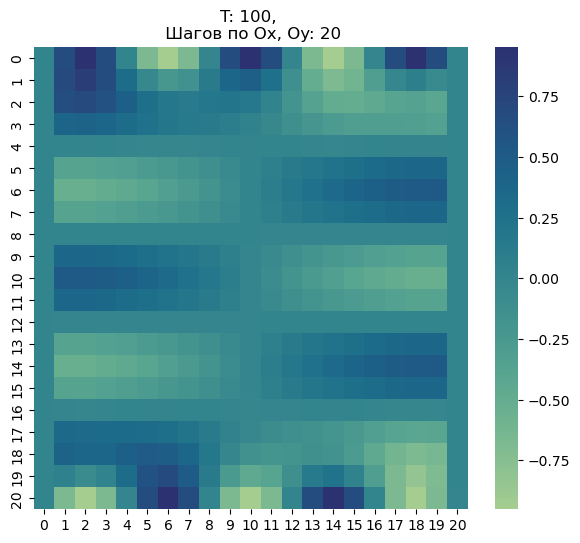

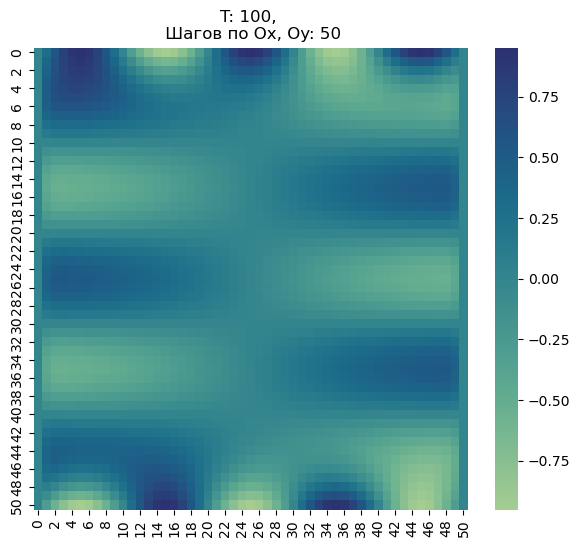

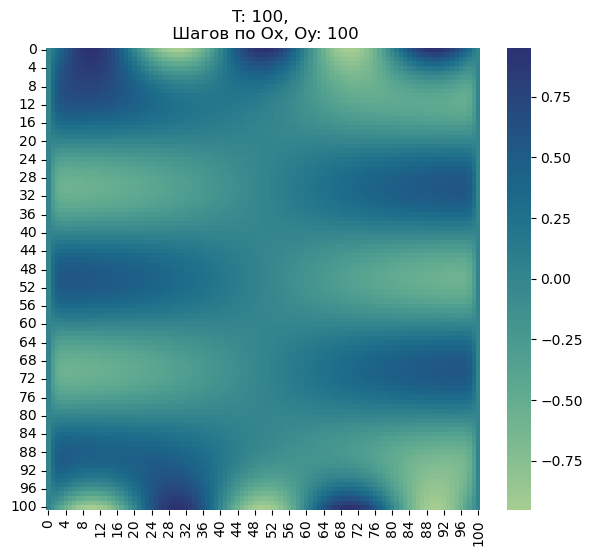

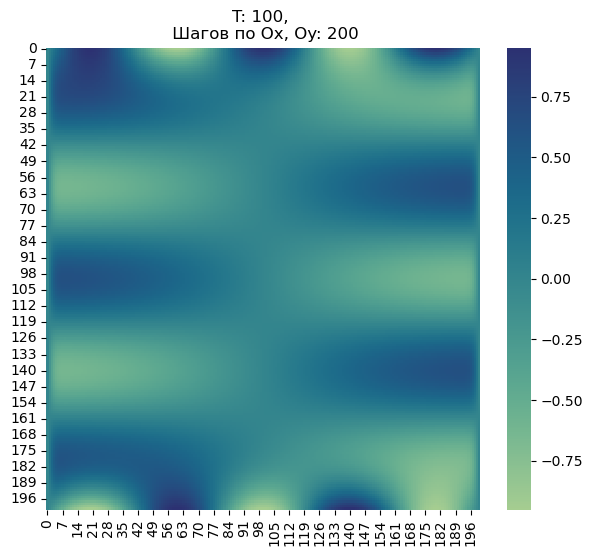

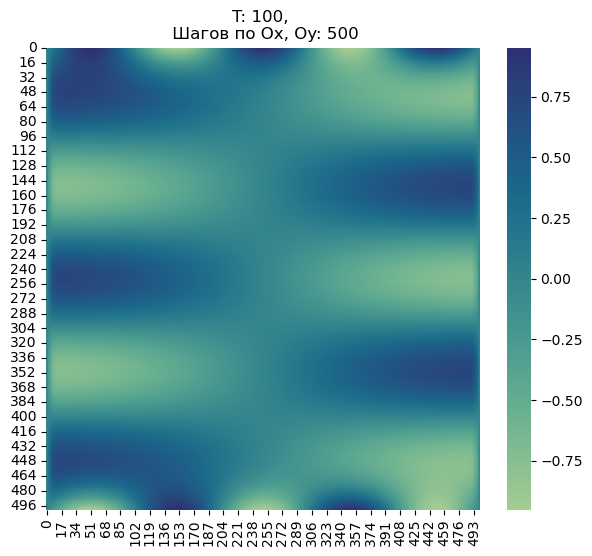

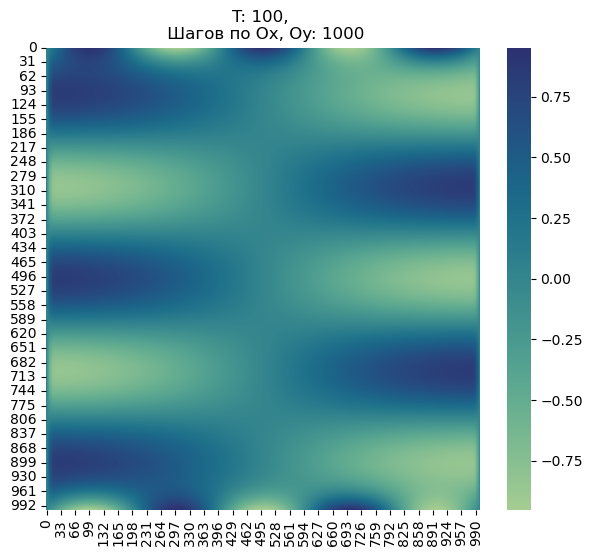

In [45]:
N_array = [ 10, 20, 50, 100, 200, 500, 1000]
delta_array, h_array = [], []

for N_XY in N_array:
    d, _, h = plot_fi(100, N_XY, if_return_h = True)
    delta_array.append(d)
    h_array.append(h)

Степень зависимости от шага: 0.93841


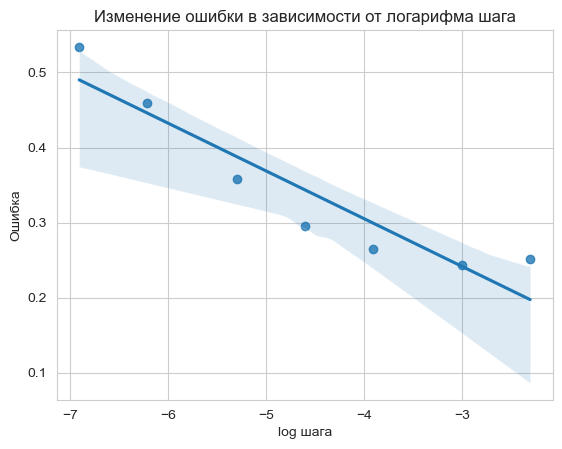

In [51]:
sns.set_style("whitegrid")

slope, intercept, _,_,_ = scipy.stats.linregress(x=np.log(h_array),
                                                       y=np.log(delta_array))
p_ugol = sns.regplot(data = pd.DataFrame({'log шагa': np.log(h_array), 'Ошибка' : np.log(delta_array)}), 
                     x= 'log шагa', y = 'Ошибка',  order = 1).set(title='Изменение ошибки в зависимости от логарифма шага')


print("Степень зависимости от шага: {:.5f}".format(np.exp(slope)))